In [ ]:
# import os
# import pandas as pd

# # Path to the folder containing images
# image_folder = '/kaggle/input/mosquito-beeding-place-dataset-model/Mosquito Beeding Place.v2-mosquito-possible-bradding-site.yolov5pytorch/train/images'

# # Load the CSV file
# csv_path = '/kaggle/input/mosquito-beeding-place-dataset-model/Image_discription.csv'
# df = pd.read_csv(csv_path)

# # Column name that contains image filenames (adjust if different)
# image_column = 'filename'

# # Get all image filenames in the folder
# folder_images = set(os.listdir(image_folder))

# # Get image names from CSV
# csv_images = df[image_column].tolist()

# # Count how many images from CSV exist in the folder
# existing_images = [img for img in csv_images if img in folder_images]
# missing_images = [img for img in csv_images if img not in folder_images]

# print(f'Total images listed in CSV: {len(csv_images)}')
# print(f'Images found in folder: {len(existing_images)}')
# print(f'Images missing from folder: {len(missing_images)}')

# # Optional: Save missing images list
# missing_df = pd.DataFrame(missing_images, columns=['missing_images'])
# missing_df.to_csv('missing_images.csv', index=False)


In [ ]:
# !pip install --upgrade pip

# !pip install torch torchvision numpy tqdm Pillow transformers

# !pip install git+https://github.com/openai/CLIP.git


In [ ]:
# !pip uninstall -y torch torchvision
# !pip cache purge
# !pip install torch==2.0.1+cu118 torchvision==0.15.2+cu118 --extra-index-url https://download.pytorch.org/whl/cu118


In [ ]:
# import torch
# import torchvision

# print(f"PyTorch version: {torch.__version__}, CUDA: {torch.version.cuda}")
# print(f"torchvision version: {torchvision.__version__}")
# print(f"CUDA available: {torch.cuda.is_available()}")


In [1]:
# ─────────────────────────────────────────────────────────────
# 1. Setup  ─ install OpenAI-CLIP & define dataset locations
# ─────────────────────────────────────────────────────────────
# !pip install -q git+https://github.com/openai/CLIP.git          # original CLIP repo
import os, json, warnings, torch, torch.nn as nn, pandas as pd
import cv2
from torch.utils.data import DataLoader
from tqdm import tqdm
import clip                                                     # now import after install

# ▶︎ EDIT THESE TWO LINES ONLY if you used a different slug when you clicked "Add Data"
DATASET_DIR   = "/kaggle/input/mosquito-beeding-place-dataset-model"
CSV_PATH      = f"{DATASET_DIR}/Image_discription.csv"

IMG_DIR       = (
    f"{DATASET_DIR}/Mosquito Beeding Place.v2-mosquito-possible-bradding-site.yolov5pytorch/"
    "train/images"
)


In [11]:

# ─────────────────────────────────────────────────────────────
# 2. Read CSV → lists of image paths and captions
# ─────────────────────────────────────────────────────────────
df = pd.read_csv(CSV_PATH)

# (rename / strip columns once, to avoid KeyErrors later)
df = df.rename(columns=str.strip)
df["caption"] = (
    df["Reasoning"].astype(str).str.strip().str.slice(0, 350)    # ≤40 chars, like your json example
)

list_image_path = [os.path.join(IMG_DIR, fn) for fn in df["filename"]]
list_txt        = df["caption"].tolist()

print(f"✔ Loaded {len(list_image_path):,} image-text pairs")


✔ Loaded 3,871 image-text pairs


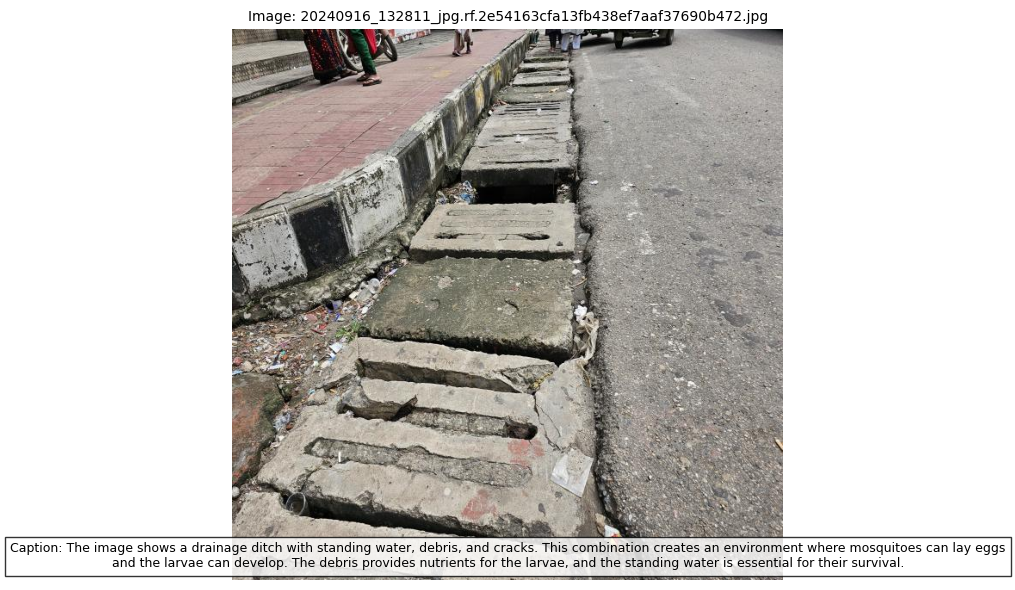

Displaying image 2312/3871
Path: /kaggle/input/mosquito-beeding-place-dataset-model/Mosquito Beeding Place.v2-mosquito-possible-bradding-site.yolov5pytorch/train/images/20240916_132811_jpg.rf.2e54163cfa13fb438ef7aaf37690b472.jpg
Caption length: 273 characters


In [12]:
# ============================================================
# 2. Display random image with caption
# ============================================================
import random
from matplotlib import pyplot as plt

random_idx = random.randint(0, len(list_image_path)-1)
img_path = list_image_path[random_idx]
caption = list_txt[random_idx]

# Read image with OpenCV
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

# Create figure
plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.title(f"Image: {os.path.basename(img_path)}", fontsize=10)
plt.axis('off')

# Add caption text (with word wrapping)
plt.figtext(0.5, 0.05, 
           f"Caption: {caption}",
           ha="center", 
           fontsize=9,
           wrap=True,
           bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

print(f"Displaying image {random_idx+1}/{len(list_image_path)}")
print(f"Path: {img_path}")
print(f"Caption length: {len(caption)} characters")

In [6]:
# ─────────────────────────────────────────────────────────────
# 3. Load CLIP model (OpenAI repo) & choose device
# ─────────────────────────────────────────────────────────────
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-L/14@336px", device=device, jit=False)


In [13]:

# ─────────────────────────────────────────────────────────────
# 4. Dataset & DataLoader
# ─────────────────────────────────────────────────────────────
class ImageTitleDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, texts):
        self.image_paths = image_paths
        self.texts       = clip.tokenize(texts)      # tokenise once
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        # Using OpenCV instead of PIL
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        image = preprocess(Image.fromarray(image))  # CLIP's preprocess expects PIL image
        return image, self.texts[idx]

dataset         = ImageTitleDataset(list_image_path, list_txt)
train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True, num_workers=4, pin_memory=True)


In [14]:

# ─────────────────────────────────────────────────────────────
# 5. Optimiser & losses
# ─────────────────────────────────────────────────────────────
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, betas=(0.9, 0.98),
                              eps=1e-6, weight_decay=0.2)
loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()

def convert_models_to_fp32(m):         # helper from OpenAI example
    for p in m.parameters():
        p.data = p.data.float()
        if p.grad is not None:
            p.grad.data = p.grad.data.float()

In [ ]:

from PIL import Image
# ─────────────────────────────────────────────────────────────
# 6. Training loop
# ─────────────────────────────────────────────────────────────
num_epochs = 30
for epoch in range(1, num_epochs + 1):
    pbar = tqdm(train_dataloader, leave=False, desc=f"Epoch {epoch}/{num_epochs}")
    for images, texts in pbar:
        optimizer.zero_grad()

        images = images.to(device, non_blocking=True)
        texts  = texts.to(device,  non_blocking=True)

        logits_per_image, logits_per_text = model(images, texts)

        ground_truth = torch.arange(len(images), dtype=torch.long, device=device)
        total_loss = (loss_img(logits_per_image, ground_truth) +
                      loss_txt(logits_per_text, ground_truth)) / 2

        total_loss.backward()
        if device == "cuda":
            convert_models_t';
            clip.model.convert_weights(model)  # keep params in fp16
        else:
            optimizer.step()

        pbar.set_postfix({"loss": f"{total_loss.item():.4f}"})

print("✅ Training finished.")

Epoch 29/30:  72%|███████▏  | 350/484 [05:24<02:04,  1.08it/s, loss=0.1835]

In [ ]:



# ─────────────────────────────────────────────────────────────
# 7. Save the fine-tuned model to /kaggle/working so you can
#    download it or attach it via "Add Data" to future notebooks
# ─────────────────────────────────────────────────────────────
SAVE_DIR = "/kaggle/working/clip-finetuned"
os.makedirs(SAVE_DIR, exist_ok=True)
torch.save(model.state_dict(), f"{SAVE_DIR}/pytorch_model.bin")
with open(f"{SAVE_DIR}/config.txt", "w") as f:
    f.write("ViT-B/32 fine-tuned on mosquito dataset")

print(f"📦 Model weights saved to {SAVE_DIR}")

#### 